<hr>
<h1><center>Web Traffic Forecasting : DL Modeling</center></h1> 
<hr>

In [3]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import gc
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import model_from_json

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.layers import Dense, concatenate, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Flatten, LSTM
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D
from tensorflow.keras import Model, Sequential

from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json

### Loading Actual Train Data 


In [4]:
complete_train = pd.read_csv('./train_2.csv')

complete_train['Site']      = complete_train['Page'].map(lambda x:x.split('_')[-3])
complete_train['Site_Name'] = complete_train['Site'].map(lambda x:x.split('.')[1])
complete_train['Language']  = complete_train['Site'].map(lambda x:x.split('.')[0])
complete_train['Access']    = complete_train['Page'].map(lambda x:x.split('_')[-2])
complete_train['Agent']     = complete_train['Page'].map(lambda x:x.split('_')[-1])

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

complete_train['Site_OHE'] = label.fit_transform(complete_train['Site_Name']).tolist()
print("Site Encoded using     : ", label.classes_)

complete_train['Lang_OHE'] = label.fit_transform(complete_train['Language']).tolist()
print("Language Encoded using : ", label.classes_)

complete_train['Access_OHE'] = label.fit_transform(complete_train['Access']).tolist()
print("Access Encoded using   : ", label.classes_)

complete_train['Agent_OHE'] = label.fit_transform(complete_train['Agent']).tolist()
print("Agent Encoded using    : ", label.classes_)

complete_train.drop(['Site', 'Site_Name', 'Language', 'Access', 'Agent'], axis=1, inplace=True)
complete_train = complete_train.fillna(0)
#complete_train.to_csv('./Transformed_train_2.csv', index=False)


#test_dates
from datetime import date, timedelta

#end of the train is Sep 20, 2017 and data to e
start = date(2017,9,11)
end   = date(2017,11,13)
no_days = end - start
test_days = [ (start+timedelta(days=x)).strftime('%Y-%m-%d') for x in range(no_days.days+1) ]
print("\n\nTest Data to run from {0} upto {1}".format(test_days[0], test_days[-1]))

Site Encoded using     :  ['mediawiki' 'wikimedia' 'wikipedia']
Language Encoded using :  ['commons' 'de' 'en' 'es' 'fr' 'ja' 'ru' 'www' 'zh']
Access Encoded using   :  ['all-access' 'desktop' 'mobile-web']
Agent Encoded using    :  ['all-agents' 'spider']


Test Data to run from 2017-09-11 upto 2017-11-13


### Loading Page-Key file

In [5]:
page_key = pd.read_csv('./key_2.csv')
page_key.head()

,Page,Id
0,007_スペクター_ja.wikipedia.org_all-access_all-agen...,0b293039387a
1,007_スペクター_ja.wikipedia.org_all-access_all-agen...,7114389dd824
2,007_スペクター_ja.wikipedia.org_all-access_all-agen...,057b02ff1f09
3,007_スペクター_ja.wikipedia.org_all-access_all-agen...,bd2aca21caa3
4,007_スペクター_ja.wikipedia.org_all-access_all-agen...,c0effb42cdd5


### Loading Train Data

In [6]:
#load data
train = pd.read_csv('./train_data.csv')
test  = pd.read_csv('./test_data.csv')

In [7]:
non_date_cols = [ x for x in train.columns.tolist() if x.endswith('_OHE') ]
date_cols = [ x for x in train.columns.tolist() if x not in non_date_cols ]

In [8]:
X_timeseries  = train[date_cols]
X_pagedata    = train[non_date_cols]
observed      = X_timeseries.iloc[:, -1]
pagename_X_te = test[non_date_cols]

### Metric for evaluation

In [9]:
def smape(ytr, ypr):
    ytr += np.log1p(0.0001)
    numerator   = np.abs(ypr - ytr)
    #print(numerator)
    denominator = (np.abs(ytr) + np.abs(ypr))
    #print(denominator)
    return (200/len(ytr) * np.sum( numerator / denominator ))


def tf_smape(ytr, ypr):
    return tf.py_function(smape, (ytr, ypr), tf.double)


def rmse(ytr, ypr):
    from math import sqrt
    from sklearn.metrics import mean_squared_error
    return sqrt(mean_squared_error(ytr, ypr))


def tf_rmse(ytr, ypr):
    return tf.py_function(rmse, (ytr, ypr), tf.double)

In [10]:
#parameters
lagged_window = [7, 30, 90, 365]
batch = 256
epoch = 20
models = dict()

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
dl_stopping = EarlyStopping(monitor='tf_smape', patience=3)

deep_epoch = 150



---



# [1] Deep Learning Models

## [1.1] Simple DNN

In [20]:
def dense_model(shape, print_summary=False):
  """
  Model returns simple Deep Neural Network for given data, given input params
  """
  model = Sequential()
  model.add(Dense(512, activation='relu', input_shape=(shape, )))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf_smape])
  if print_summary:
      model.summary()
  return model

#### [1.1.1] Hyper Parameter Tuning

In [ ]:
error = list()
for lag in lagged_window:
  clear_session()
  print("**** Running for Lag = ",lag)
  X = np.log1p(X_timeseries.iloc[:,-lag-1:-1])
  #X = X_timeseries.iloc[:,-lag-1:-1]
  observed = X_timeseries.iloc[:,-1]
  Y = np.log1p(X_timeseries.iloc[:,-1])
  #Y = X_timeseries.iloc[:,-1]
  #print("Dataset shape is ",X.shape)
  model = dense_model(lag)
  model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=0)  
  predicted = np.ceil(np.expm1(model.predict(X)))
  #predicted = np.ceil(model.predict(X))
  predicted = np.array(predicted).reshape((X.shape[0]))
  cv_smape = smape(observed, predicted)
  error.append([cv_smape, lag])
  print("SMAPE = {0} for lag = {1}".format(cv_smape, lag))

index         = np.argmin([ x[0] for x in error ])
best_window   = error[index][1]
best_cv_smape = error[index][0]
 
print("\n\nBest Values are : \n",best_window, "\n", "Best SMAPE on CV data is ",best_cv_smape)

**** Running for Lag =  7
SMAPE = 33.00412664190798 for lag = 7
**** Running for Lag =  30
SMAPE = 33.479609194460465 for lag = 30
**** Running for Lag =  90
SMAPE = 31.717767144881265 for lag = 90
**** Running for Lag =  365
SMAPE = 32.75959930484306 for lag = 365


Best Values are : 
 90 
 Best SMAPE on CV data is  31.717767144881265


#### [1.1.2] Fitting Model with Best Window

In [21]:
best_window = 90
print("Model is trained and found to have : ")
print("Best Window = ",best_window)
print("\n\n")
gc.collect()
X = np.log1p(X_timeseries.iloc[:,-best_window-1:-1])
Y = np.log1p(X_timeseries.iloc[:,-1])
 
#fitting model with best parameters
model = dense_model(best_window, print_summary=True)
model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)
 
#save the model weights
my_model = model.to_json()
with open("copy_dnn_model.json", "w") as json_file:
  json_file.write(my_model)
model.save_weights("copy_dnn_model_weights.h5")

Model is trained and found to have : 
Best Window =  90



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               46592     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 121,041
Trainable params: 121,041
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
567/567 [==============================] - 4s 

#### [1.1.3] CV data Analysis 

In [ ]:
#history of values
history = X_timeseries.iloc[:, -best_window:]
gc.collect()
clear_session()
#testing the model on test data
test_data = pd.DataFrame()
test_cols = test.columns.tolist()
for col in tqdm(test_cols[:-4]):
  X = np.log1p(history.iloc[:,-best_window:])
  #X = history.iloc[:,-best_window:]
  predict = np.ceil(np.expm1(model.predict(X)))
  #predict = np.ceil(model.predict(X))
  predict = np.array(predict).reshape((X.shape[0]))
  test_data[col] = predict
  history[col]   = predict
 
#checking SMAPE on forecasted and actual CV values
cv_smape = np.mean(smape(test.iloc[:,:-4], test_data))
print("\nSMAPE on CV data = ",cv_smape)
models['DNN Model'] = [best_window, cv_smape]

100%|██████████| 73/73 [04:32<00:00,  3.73s/it]



SMAPE on CV data =  52.22553137457099


#### [1.1.4] CV SMAPE Performance

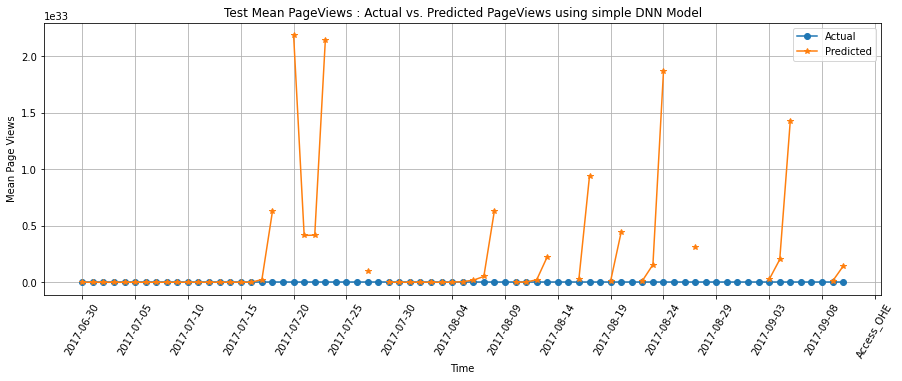

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using simple DNN Model')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)

xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]
b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

## [1.2] Simple LSTM

In [28]:
def lstm(shape, print_summary=False):
    """
    simple 2 layered LSTM model for data. Returns the compiled model with 
    passed parameters.
    """
    model = Sequential()
    model.add(LSTM(16, activation='relu', return_sequences=True, input_shape=(shape, 1)))
    model.add(LSTM(16, activation='relu'))
    model.add(Dropout(0.20))
    #model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf_smape])
    if print_summary:
        model.summary()
    return model

#### [1.2.1] Hyper Parameter Tuning

In [4]:
gc.collect()
error = list()
for lag in lagged_window:
  clear_session()
  print("**** Running for Lag=",lag)
  X = np.log1p(X_timeseries.iloc[:,-lag-1:-1])
  #X = X_timeseries.iloc[:,-lag-1:-1]
  r, c  = X.shape
  X = np.array(X).reshape((r, c, 1))
  Y = np.log1p(X_timeseries.iloc[:,-1])
  observed = X_timeseries.iloc[:, -1]
  #Y = X_timeseries.iloc[:,-1]
  #print("Dataset shape is ",X.shape)
  model = lstm(lag)
  model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)
  predicted = np.ceil(np.expm1(model.predict(X)))
  #predicted = np.ceil(model.predict(X))
  predicted = np.array(predicted).reshape((X.shape[0]))
  #tr_smape = smape(Y, predicted)
  cv_smape = np.mean(smape(observed, predicted))
  print("SMAPE for Lag=%d is %f"%(lag, cv_smape))
  error.append([cv_smape, lag])
 
index         = np.argmin([ x[0] for x in error ])
best_window   = error[index][1]
best_cv_smape = error[index][0]
 
print("\n\nBest Values are : \n",best_window, "\n", best_cv_smape)


**** Running for Lag= 7
SMAPE for Lag=7 is 33.978622
**** Running for Lag= 30
SMAPE for Lag=30 is 33.208534
**** Running for Lag= 90
SMAPE for Lag=90 is 77.149977
**** Running for Lag= 365
SMAPE for Lag=90 is nan


Best Values are : 
 30 
 33.20853431493801



#### [1.2.2] Fitting Model with Best Window

In [5]:
print("Model is trained and found to have : ")
print("Best Window = ",best_window)
print("\n\n")

#fiting model with best parameters
X = np.log1p(X_timeseries.iloc[:,-best_window-1:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(X_timeseries.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]
 
#fitting model wth best parameters
clear_session()
model = lstm(best_window, print_summary=True)
model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)
 
#save the model weights
my_model = model.to_json()
with open("copy_lstm_model.json", "w") as json_file:
  json_file.write(my_model)
model.save_weights("copy_lstm_model_weights.h5")


Model is trained and found to have : 
Best Window =  30



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 16)            1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
145063/145063 [==============================] - 35s 244us/sample - loss: 1.7801 - tf_smape: 32.7476
Epoch 2/20
145063/145063 [==============================] - 36s 248us/sample - loss: 1.0008 - tf_sma

#### [1.2.3] CV data Analysis 

In [2]:
#history of values
history = X_timeseries.iloc[:, -best_window:]
gc.collect()
#testing the model on test data
test_data = pd.DataFrame()
test_cols = test.columns.tolist()
for col in tqdm(test_cols[:-4]):
  clear_session()
  X = np.log1p(history.iloc[:,-best_window:])
  #X = history.iloc[:,-best_window:]
  r, c = X.shape
  X = np.array(X).reshape((r, c, 1))
  predict = np.ceil(np.expm1(model.predict(X)))
  #predict = np.ceil(model.predict(X))
  predict = np.array(predict).reshape((X.shape[0]))
  test_data[col] = predict
  history[col]   = predict

#checking SMAPE on forecasted and actual CV values
cv_smape = np.mean(smape(test.iloc[:,:-4], test_data))
print("\nSMAPE on CV data = ",cv_smape)
models['LSTM Model'] = [best_window, cv_smape]

SMAPE on CV data =  94.2299259028066


#### [1.2.4] CV SMAPE Performance

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using simple LSTM Model')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)
 
xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]
b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

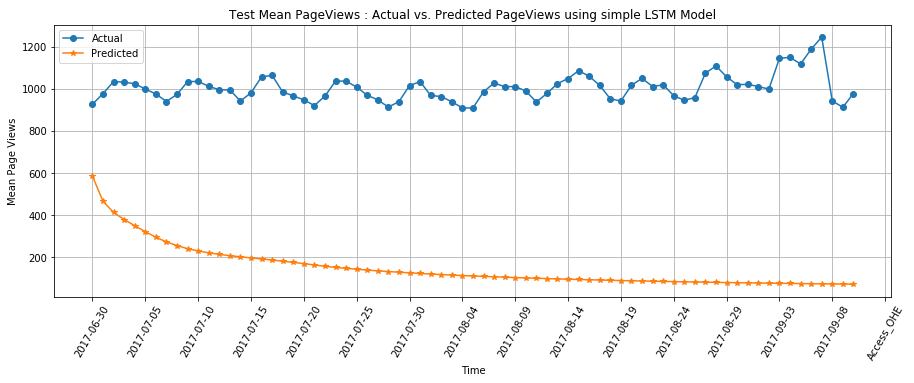

## [1.3] CNN Model

In [29]:
def cnn_model(shape, print_summary=False):
  """
  function that takes paramter and returns simple CNN model
  """
  model = Sequential()
  #adding convolution layer
  model.add(Conv1D(filters=128, kernel_size=2, activation='relu', \
                   kernel_initializer = 'he_uniform', input_shape=(shape, 1)))
  model.add(Conv1D(filters=128, kernel_size=2, activation='relu', \
                   kernel_initializer = 'he_uniform'))
  model.add(MaxPooling1D(pool_size=3))
  #flatten the model output
  model.add(Flatten())
  #add Dense layers
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))
  #compile model with loss and metrics
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf_smape])
  #return model and Print is necessary
  if print_summary:
    model.summary()
  return model

#### [1.3.1] Hyper Parameter Tuning

In [ ]:
gc.collect()
error = list()
for lag in lagged_window:
  print("**** Running for Lag=",lag)
  clear_session()
  X = np.log1p(X_timeseries.iloc[:,-lag-1:-1])
  #X = X_timeseries.iloc[:,-lag-1:-1]
  r, c  = X.shape
  X = np.array(X).reshape((r, c, 1))
  Y = np.log1p(X_timeseries.iloc[:,-1])
  #Y = X_timeseries.iloc[:,-1]
  observed = X_timeseries.iloc[:, -1]
  #print("Dataset shape is ",X.shape)
  model = cnn_model(lag)
  model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=0)
  predicted = np.ceil(np.expm1(model.predict(X)))
  #predicted = np.ceil(model.predict(X))
  predicted = np.array(predicted).reshape((X.shape[0]))
  #tr_smape = smape(Y, predicted)
  cv_smape = np.mean(smape(observed, predicted))
  error.append([cv_smape, lag])
  print("SMAPE = {0} for Lag = {1}".format(cv_smape, lag))
index         = np.argmin([ x[0] for x in error ])
best_window   = error[index][1]
best_cv_smape = error[index][0]
 
print("\n\nBest Values are : \n",best_window, "\n", "Best SMAPE on CV data is ",best_cv_smape)

**** Running for Lag= 7
SMAPE = 36.903023985148906 for Lag = 7
**** Running for Lag= 30
SMAPE = 37.92718723119423 for Lag = 30
**** Running for Lag= 90
SMAPE = 33.94058462715518 for Lag = 90
**** Running for Lag= 365
SMAPE = 45.45721823042916 for Lag = 365


Best Values are : 
 90 
 Best SMAPE on CV data is  33.94058462715518


#### [1.3.2] Fitting Model with Best Window

In [ ]:
#best_window = 30
print("Model is trained and found to have : ")
print("Best Window = "    ,best_window)
print("\n\n")
gc.collect()

X = np.log1p(X_timeseries.iloc[:,-best_window-1:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(X_timeseries.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]
 
#fitting model wth best parameters
model = cnn_model(best_window, print_summary=True)
model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)
 
#save the model weights
my_model = model.to_json()
with open("copy_cnn_model.json", "w") as json_file:
  json_file.write(my_model)
model.save_weights("copy_cnn_model_weights.h5")

Model is trained and found to have : 
Best Window =  90



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 89, 128)           384       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 88, 128)           32896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3712)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                118816    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 152,129
Trainable params: 152,129
Non-trainable

#### [1.3.3] CV data Analysis 

In [ ]:
#history of values
history = X_timeseries.iloc[:, -best_window:]
 
#testing the model on test data
test_data = pd.DataFrame()
test_cols = test.columns.tolist()
for col in tqdm(test_cols[:-4]):
  clear_session()
  X = np.log1p(history.iloc[:,-best_window:])
  #X = history.iloc[:,-best_window:]
  r, c = X.shape
  X = np.array(X).reshape((r, c, 1))
  predict = np.ceil(np.expm1(model.predict(X)))
  #predict = np.ceil(model.predict(X))
  predict = np.array(predict).reshape((X.shape[0]))
  test_data[col] = predict
  history[col]   = predict
 
#checking SMAPE on forecasted and actual CV values
cv_smape = np.mean(smape(test.iloc[:,:-4], test_data))
print("\nSMAPE on CV data = ",cv_smape)
models['CNN Model'] = [best_window, cv_smape]

100%|██████████| 73/73 [34:32<00:00, 28.39s/it]



SMAPE on CV data =  57.822529574117574


#### [1.3.4] CV SMAPE Performance

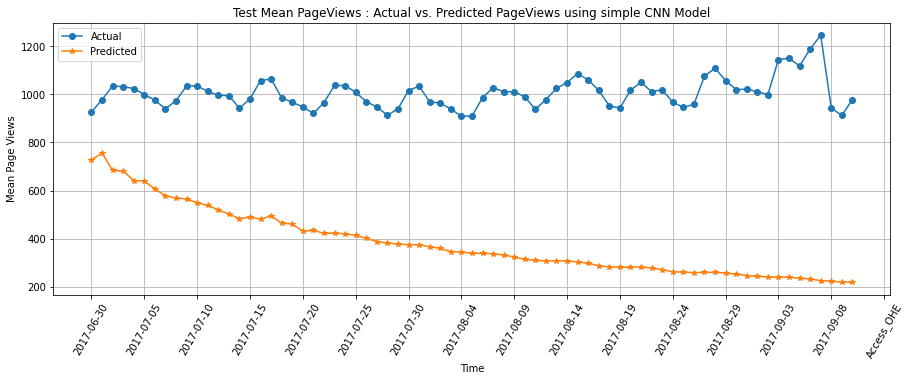

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using simple CNN Model')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)
 
xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]
b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

## [1.4] CNN-LSTM

In [30]:
def cnn_lstm_model(shape, print_summary=False):
    model = Sequential()
    #adding convolution layer
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', \
                     kernel_initializer = 'he_uniform', input_shape=(shape, 1)))
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', \
                     kernel_initializer = 'he_uniform'))
    model.add(MaxPooling1D(pool_size=3))
    #model.add(Flatten())
    #adding LSTM layer
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu'))
    #flatten the model output
    #model.add(Flatten())
    #add Dense layers
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.20))
    model.add(Dense(1))
 
    #compile model with loss and metrics
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf_smape])
    #return model and Print is necessary
    if print_summary:
      model.summary()
    return model

#### [1.4.1] Hyper Parameter Tuning

In [3]:
gc.collect()
error = list()
for lag in lagged_window:
  clear_session()
  print("**** Running for Lag=",lag)
  X = np.log1p(X_timeseries.iloc[:,-lag-1:-1])
  #X = X_timeseries.iloc[:,-lag-1:-1]
  r, c  = X.shape
  X = np.array(X).reshape((r, c, 1))
  Y = np.log1p(X_timeseries.iloc[:,-1])
  observed = X_timeseries.iloc[:,-1]
  #Y = X_timeseries.iloc[:,-1]
  #print("Dataset shape is ",X.shape)
  model = cnn_lstm_model(lag)
  model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)
  predicted = np.ceil(np.expm1(model.predict(X)))
  #predicted = np.ceil(model.predict(X))
  predicted = np.array(predicted).reshape((X.shape[0]))
  #tr_smape = smape(Y, predicted)
  cv_smape = np.mean(smape(observed, predicted))
  error.append([cv_smape, lag])
  print("SMAPE = {0} for Lag = {1}".format(cv_smape, lag))

index         = np.argmin([ x[0] for x in error ])
best_window   = error[index][1]
best_cv_smape = error[index][0]
 
print("\n\nBest Values are : \n",best_window, "\n", "Best SMAPE on CV data is ",best_cv_smape)


**** Running for Lag= 7
SMAPE = 39.37963930453302 for Lag = 7
**** Running for Lag= 30
SMAPE = 40.214171562408254 for Lag = 30
**** Running for Lag= 90
SMAPE = 125.42138458837948 for Lag = 90
**** Running for Lag= 365
SMAPE = nan for Lag = 365


Best Values are : 
 7
 Best SMAPE on CV data is 39.37963930453302



#### [1.4.2] Fitting Model with Best Window

In [ ]:
best_window = 7
print("Model is trained and found to have : ")
print("Best Window = ",best_window)
print("\n\n")
gc.collect()
X = np.log1p(X_timeseries.iloc[:,-best_window-1:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(X_timeseries.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]
 
#fitting model wth best parameters
model = cnn_lstm_model(best_window, print_summary=True)
model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)
 
#save the model weights
my_model = model.to_json()
with open("copy_cnn_lstm_model.json", "w") as json_file:
  json_file.write(my_model)
model.save_weights("copy_cnn_lstm_model_weights.h5")

Model is trained and found to have : 
Best Window =  7



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 128)            384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            32896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
________________________________________________________________

#### [1.4.3] CV data Analysis

In [ ]:
#history of values
history = X_timeseries.iloc[:, -best_window:]
 
gc.collect()
#testing the model on test data
test_data = pd.DataFrame()
test_cols = test.columns.tolist()
for col in tqdm(test_cols[:-4]):
  clear_session()
  X = np.log1p(history.iloc[:,-best_window:])
  #X = history.iloc[:,-best_window:]
  r, c = X.shape
  X = np.array(X).reshape((r, c, 1))
  predict = np.ceil(np.expm1(model.predict(X, batch_size=batch, use_multiprocessing=True)))
  #predict = np.ceil(model.predict(X))
  predict = np.array(predict).reshape((X.shape[0]))
  test_data[col] = predict
  history[col]   = predict
 
#checking SMAPE on forecasted and actual CV values
cv_smape = np.mean(smape(test.iloc[:,:-4], test_data))
print("\nSMAPE on CV data = ",cv_smape)
models['CNN-LSTM Model'] = [best_window, cv_smape]

100%|██████████| 73/73 [05:00<00:00,  4.12s/it]



SMAPE on CV data =  97.02710490172983


#### [1.4.4] CV SMAPE Performance

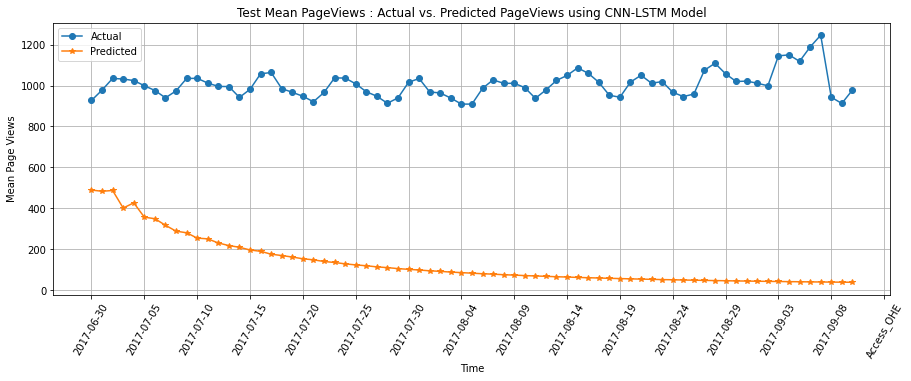

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using CNN-LSTM Model')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)
 
xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]
b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

## [2] Conclusion : Model Performance 

In [8]:
from prettytable import PrettyTable
dl_models = PrettyTable(['Model', 'Best Window', 'CV performance'])

for k, v in models.items():
  dl_models.add_row([k, v[0], round(v[1], 4)])

print(dl_models)

+----------------+-------------+----------------+
|     Model      | Best Window | CV performance |
+----------------+-------------+----------------+
|   DNN Model    |      90     |    52.2255     |
|   LSTM Model   |      30     |    84.4969     |
|   CNN Model    |      90     |    57.8225     |
| CNN-LSTM Model |      7      |    97.0271     |
+----------------+-------------+----------------+


<p>From above, we can see that Models, DNN, CNN and LSTM gives least SMAPE with CV data.</p>

<p>We will prepare the test forecasting of these models as well as increase the layers of the LSTM and CNN models to check if they perform better or not</p>

## [3] On Test Data

In [ ]:
models = dict()

## [3.1] Test Data Analysis : DNN Model

In [ ]:
#load the model weights
with open('copy_dnn_model.json', 'r') as f:
    model = model_from_json(f.read())
# Load weights into the new model
model.load_weights('copy_dnn_model_weights.h5')

In [22]:
best_window = 90
print("DNN Model is trained and found to have Best_Window of %d"%best_window)

past_data_cols = complete_train.columns.tolist()[-best_window-5:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
timeseries_X = complete_train[date_cols]

DNN Model is trained and found to have Best_Window of 90


In [23]:
X = np.log1p(timeseries_X.iloc[:,:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(timeseries_X.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]

#from tensorflow.keras.models import model_from_json
#with open('complex_lstm_model.json', 'r') as f:
#    model = model_from_json(f.read())
## Load weights into the new model
#model.load_weights('complex_lstm_model_weights.h5')
model.summary()

#model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               46592     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 121,041
Trainable params: 121,041
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
#print(past_data.shape)
for test_index in range(len(test_days)):
    #clear_session()
    print("Remaining are %d"%(len(test_days)-test_index+1))
    #print(history.shape)
    X = np.log1p(timeseries_X.iloc[:,-best_window:])
    r, c = X.shape
    #X = np.array(X).reshape((r, c, 1))
    #X_lagged = np.hstack((X_pagename_te, X))
    predicted = np.ceil(np.expm1(model.predict(X)))
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [26]:
f = open('simple_dnn_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
test_data_final = pd.read_csv('./simple_dnn_Page_Count.csv', sep='|')  

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_simple_dnn.csv', index=False)

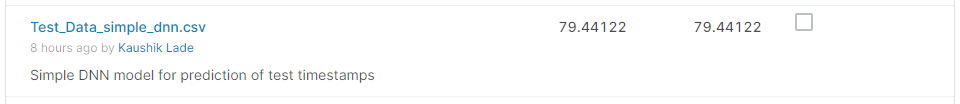

In [ ]:
models['DNN Model'] = [best_window, cv_smape, 79.44122]

## [3.2] Test Data Analysis : CNN Model

In [34]:
best_window = 90
print("CNN Model is trained and found to have Best_Window of %d"%best_window)


past_data_cols = complete_train.columns.tolist()[-best_window-5:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

CNN Model is trained and found to have Best_Window of 90


In [36]:
X = np.log1p(timeseries_X.iloc[:,-best_window-1:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(timeseries_X.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]
 
from tensorflow.keras.models import model_from_json
with open('copy_cnn_model.json', 'r') as f:
    model = model_from_json(f.read())
# Load weights into the new model
model.load_weights('copy_cnn_model_weights.h5')
model.summary()

#model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 89, 128)           384       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 88, 128)           32896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3712)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                118816    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 152,129
Trainable params: 152,129
Non-trainable params: 0
________________________________________________

In [ ]:
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
#print(past_data.shape)
for test_index in range(len(test_days)):
    #clear_session()
    print("Remaining are %d"%(len(test_days)-test_index+1))
    #print(history.shape)
    X = np.log1p(timeseries_X.iloc[:,-best_window:])
    r, c = X.shape
    X = np.array(X).reshape((r, c, 1))
    #X_lagged = np.hstack((X_pagename_te, X))
    predicted = np.ceil(np.expm1(model.predict(X)))
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [43]:
f = open('CNN_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
test_data_final = pd.read_csv('./CNN_Page_Count.csv', sep='|')  

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_CNN.csv', index=False)

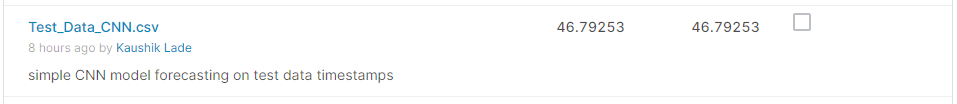

In [ ]:
models['CNN Model'] = [best_window, cv_smape, 46.79253]

## [3.3] Test Data Analysis : LSTM Model

In [12]:
best_window = 30
print("LSTM Model is trained and found to have Best_Window of %d"%best_window)


past_data_cols = complete_train.columns.tolist()[-best_window-5:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
pagename_X   = complete_train[non_date]
timeseries_X = complete_train[date_cols]

LSTM Model is trained and found to have Best_Window of 30


In [13]:
X = np.log1p(timeseries_X.iloc[:,:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(timeseries_X.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]
 
#fitting model wth best parameters
#model = lstm(best_window, print_summary=True)

from tensorflow.keras.models import model_from_json
with open('copy_lstm_model.json', 'r') as f:
    model = model_from_json(f.read())
# Load weights into the new model
model.load_weights('copy_lstm_model_weights.h5')
model.summary()

#model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 16)            1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
#print(past_data.shape)
for test_index in range(len(test_days)):
    #clear_session()
    print("Remaining are %d"%(len(test_days)-test_index+1))
    #print(history.shape)
    X = np.log1p(timeseries_X.iloc[:,-best_window:])
    r, c = X.shape
    X = np.array(X).reshape((r, c, 1))
    #X_lagged = np.hstack((X_pagename_te, X))
    predicted = np.ceil(np.expm1(model.predict(X)))
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [15]:
f = open('simple_LSTM_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
test_data_final = pd.read_csv('./simple_LSTM_Page_Count.csv', sep='|')  

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_simple_LSTM.csv', index=False)

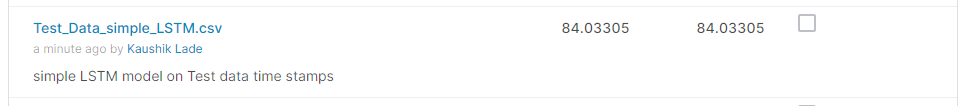

In [ ]:
models['LSTM Model'] = [ best_window, cv_smape, 84.03305]



---



## [4] Increasing the complexity of DL Models

## [4.1] Complex LSTM Model

In [ ]:
clear_session()

In [ ]:
def complex_lstm(shape, print_summary=False):
    """
    simple 2 layered LSTM model for data. Returns the compiled model with 
    passed parameters.
    """
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(shape, 1)))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.20))
    #model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dropout(0.20))
    #model.add(Flatten())
    #model.add(Dense(16, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(8, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf_smape])
    if print_summary:
        model.summary()
    return model

#### [4.1.1] Hyper Parameter Tuning

In [47]:
gc.collect()
error = list()
for lag in sorted(lagged_window, reverse=True):
  clear_session()
  print("**** Running for Lag=",lag)
  X = np.log1p(X_timeseries.iloc[:,-lag-1:-1])
  #X = X_timeseries.iloc[:,-lag-1:-1]
  r, c  = X.shape
  X = np.array(X).reshape((r, c, 1))
  Y = np.log1p(X_timeseries.iloc[:,-1])
  observed = X_timeseries.iloc[:, -1]
  #Y = X_timeseries.iloc[:,-1]
  #print("Dataset shape is ",X.shape)
  model = complex_lstm(lag, print_summary=False)
  model.fit(X, Y, batch_size=batch, epochs=deep_epoch, verbose=1, \
            callbacks=[dl_stopping])
  predicted = np.ceil(np.expm1(model.predict(X)))
  #predicted = np.ceil(model.predict(X))
  predicted = np.array(predicted).reshape((X.shape[0]))
  #tr_smape = smape(Y, predicted)
  cv_smape = np.mean(smape(observed, predicted))
  print("SMAPE for Lag=%d is %f"%(lag, cv_smape))
  error.append([cv_smape, lag])
 
index         = np.argmin([ x[0] for x in error ])
best_window   = error[index][1]
best_cv_smape = error[index][0]
 
print("\n\nBest Values are : \n",best_window, "\n", best_cv_smape)


**** Running for Lag= 7
SMAPE for Lag=7 is 31.909865
**** Running for Lag= 30
SMAPE for Lag=30 is 33.070041
**** Running for Lag= 90
SMAPE for Lag=90 is 39.066548
**** Running for Lag= 365
SMAPE for Lag=365 is nan



#### [4.1.2] Fitting model with Best Window

In [39]:
print("Model is trained and found to have : ")
print("Best Window = ",best_window)
print("\n\n")

#fiting model with best parameters
X = np.log1p(X_timeseries.iloc[:,-best_window-1:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(X_timeseries.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]
 
#fitting model wth best parameters
clear_session()
model = complex_lstm(best_window, print_summary=True)
model.fit(X, Y, batch_size=batch, epochs=deep_epoch, \
          verbose=1, callbacks=[dl_stopping])
 
#save the model weights
my_model = model.to_json()
with open("complex_lstm_model.json", "w") as json_file:
  json_file.write(my_model)
model.save_weights("complex_lstm_model_weights.h5")


Model is trained and found to have : 
Best Window =  7



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_______________________________________________________________

#### [4.1.3] CV data Analysis

In [ ]:

#history of values
history = X_timeseries.iloc[:, -best_window:]
gc.collect()
#testing the model on test data
test_data = pd.DataFrame()
test_cols = test.columns.tolist()
for col in (test_cols[:-4]):
  clear_session()
  X = np.log1p(history.iloc[:,-best_window:])
  #X = history.iloc[:,-best_window:]
  r, c = X.shape
  X = np.array(X).reshape((r, c, 1))
  predict = np.ceil(np.expm1(model.predict(X, use_multiprocessing=True)))
  #predict = np.ceil(model.predict(X))
  predict = np.array(predict).reshape((X.shape[0]))
  test_data[col] = predict
  history[col]   = predict

#checking SMAPE on forecasted and actual CV values
cv_smape = np.mean(smape(test.iloc[:,:-4], test_data))
print("\nSMAPE on CV data = ",cv_smape)
models['LSTM Model'] = [best_window, cv_smape]


SMAPE on CV data =  91.03182489986288


#### [4.1.4] CV SMAPE Performance

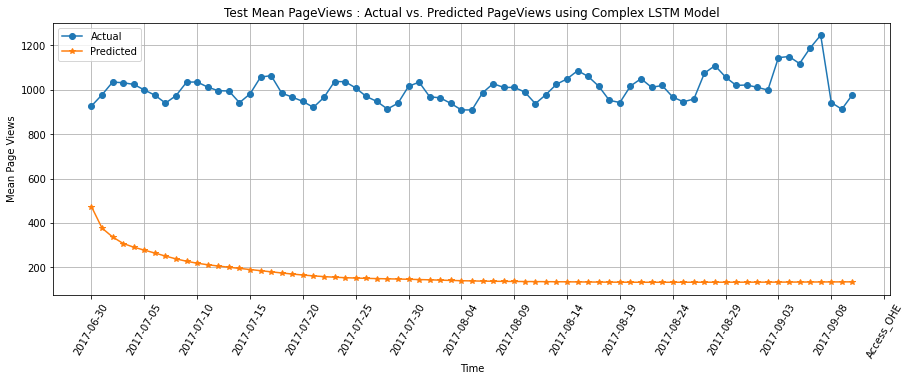

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using Complex LSTM Model')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)
 
xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]
b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

#### [4.1.5] On Test Data

In [48]:
#load the model weights
with open('complex_lstm_model.json', 'r') as f:
    model = model_from_json(f.read())
# Load weights into the new model
model.load_weights('complex_lstm_model_weights.h5')

In [49]:
best_window = 7
print("LSTM Model is trained and found to have Best_Window of %d"%best_window)

past_data_cols = complete_train.columns.tolist()[-best_window-5:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
timeseries_X = complete_train[date_cols]

LSTM Model is trained and found to have Best_Window of 7


In [50]:
X = np.log1p(timeseries_X.iloc[:,:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(timeseries_X.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]

from tensorflow.keras.models import model_from_json
with open('complex_lstm_model.json', 'r') as f:
    model = model_from_json(f.read())
# Load weights into the new model
model.load_weights('complex_lstm_model_weights.h5')
model.summary()

#model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 128)            131584    
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0

In [ ]:
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
#print(past_data.shape)
for test_index in range(len(test_days)):
    #clear_session()
    print("Remaining are %d"%(len(test_days)-test_index+1))
    #print(history.shape)
    X = np.log1p(timeseries_X.iloc[:,-best_window:])
    r, c = X.shape
    X = np.array(X).reshape((r, c, 1))
    #X_lagged = np.hstack((X_pagename_te, X))
    predicted = np.ceil(np.expm1(model.predict(X)))
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [52]:
f = open('Complex_LSTM_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
test_data_final = pd.read_csv('./Complex_LSTM_Page_Count.csv', sep='|')  

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_Complex_LSTM.csv', index=False)

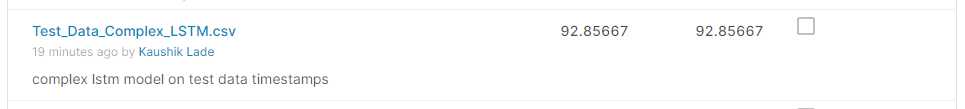

In [ ]:
models['Complex LSTM Models'] = [best_window, cv_smape, 92.85667 ]



---



## [4.2] Complex CNN Model

In [ ]:
def complex_cnn_model(shape, print_summary=False):
  """
  function that takes paramter and returns simple CNN model
  """
  model = Sequential()
  #first layer of CNN Models
  model.add(Conv1D(filters=32, kernel_size=2, padding='same', \
                   activation='relu', kernel_initializer = 'he_uniform', \
                   input_shape=(shape, 1)))
  model.add(Conv1D(filters=32, kernel_size=2, padding='same', \
                   activation='relu', kernel_initializer = 'he_uniform'))
  model.add(MaxPooling1D(pool_size=2))
  #second layer of CNN Models
  model.add(Conv1D(filters=32, kernel_size=2, padding='same', \
                   activation='relu', kernel_initializer = 'he_uniform'))
  model.add(Conv1D(filters=32, kernel_size=2, \
                   activation='relu', kernel_initializer = 'he_uniform'))
  model.add(MaxPooling1D(pool_size=2))
  #flatten the model output
  model.add(Flatten())
  #add Dense layers
  #model.add(Dense(16, activation='relu'))
  #model.add(Dropout(0.5))
  #model.add(Dense(16, activation='relu'))
  #model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))
  #compile model with loss and metrics
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf_smape])
  #return model and Print is necessary
  if print_summary:
    model.summary()
  return model

#### [4.2.1] Hyper Parameter Tuning

In [40]:
gc.collect()
error = list()
for lag in sorted(lagged_window, reverse=True):
  print("**** Running for Lag=",lag)
  clear_session()
  X = np.log1p(X_timeseries.iloc[:,-lag-1:-1])
  #X = X_timeseries.iloc[:,-lag-1:-1]
  r, c  = X.shape
  X = np.array(X).reshape((r, c, 1))
  Y = np.log1p(X_timeseries.iloc[:,-1])
  #Y = X_timeseries.iloc[:,-1]
  observed = X_timeseries.iloc[:, -1]
  #print("Dataset shape is ",X.shape)
  model = complex_cnn_model(lag)
  model.fit(X, Y, batch_size=batch, epochs=deep_epoch, \
            verbose=1, callbacks=[dl_stopping])
  predicted = np.ceil(np.expm1(model.predict(X)))
  #predicted = np.ceil(model.predict(X))
  predicted = np.array(predicted).reshape((X.shape[0]))
  #tr_smape = smape(Y, predicted)
  cv_smape = np.mean(smape(observed, predicted))
  error.append([cv_smape, lag])
  print("SMAPE = {0} for Lag = {1}".format(cv_smape, lag))
index         = np.argmin([ x[0] for x in error ])
best_window   = error[index][1]
best_cv_smape = error[index][0]
 
print("\n\nBest Values are : \n",best_window, "\n", "Best SMAPE on CV data is ",best_cv_smape)
a = gc.collect()


**** Running for Lag= 365
SMAPE = 32.53622030907409 for Lag = 365
**** Running for Lag= 90
SMAPE = 32.08136539761829 for Lag = 90
**** Running for Lag= 30
SMAPE = 32.14619961091478 for Lag = 30
**** Running for Lag= 7
SMAPE = 33.407790513449505 for Lag = 7


Best Values are : 
 90 
 Best SMAPE on CV data is  32.08136539761829



#### [4.2.2] Fitting model with Best Window

In [41]:
print("Model is trained and found to have : ")
print("Best Window = "    ,best_window)
print("\n\n")
gc.collect()
 
X = np.log1p(X_timeseries.iloc[:,-best_window-1:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(X_timeseries.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]
 
#fitting model wth best parameters
model = complex_cnn_model(best_window, print_summary=True)
model.fit(X, Y, batch_size=batch, epochs=deep_epoch, \
          verbose=1, callbacks=[dl_stopping])
 
#save the model weights
my_model = model.to_json()
with open("complex_cnn_model.json", "w") as json_file:
  json_file.write(my_model)
model.save_weights("complex_cnn_model_weights.h5")


Model is trained and found to have : 
Best Window =  90



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 90, 32)            96        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 90, 32)            2080      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 45, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 45, 32)            2080      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 44, 32)            2080      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 22, 32)            0         
____________________________________________________________

#### [4.2.3] CV data Analysis

In [42]:
with open('complex_cnn_model.json', 'r') as f:
    model = model_from_json(f.read())
# Load weights into the new model
model.load_weights('complex_cnn_model_weights.h5')
 
gc.collect()
#history of values
history = X_timeseries.iloc[:, -best_window:]
 
#testing the model on test data
test_data = pd.DataFrame()
test_cols = test.columns.tolist()
for col in (test_cols[:-4]):
  clear_session()
  X = np.log1p(history.iloc[:,-best_window:])
  #X = history.iloc[:,-best_window:]
  r, c = X.shape
  X = np.array(X).reshape((r, c, 1))
  predict = np.ceil(np.expm1(model.predict(X)))
  #predict = np.ceil(model.predict(X))
  predict = np.array(predict).reshape((X.shape[0]))
  test_data[col] = predict
  history[col]   = predict
 
#checking SMAPE on forecasted and actual CV values
cv_smape = np.mean(smape(test.iloc[:,:-4], test_data))
print("\nSMAPE on CV data = ",cv_smape)
models['CNN Model'] = [best_window, cv_smape]


100%|██████████| 73/73 [17:14<00:00, 14.17s/it]

SMAPE on CV data =  55.56740122259976



#### [4.2.4] CV SMAPE Performance

In [ ]:
#plot for mean of actual test and predicted test
plt.figure(figsize=(15, 5))
plt.title('Test Mean PageViews : Actual vs. Predicted PageViews using Complex CNN Model')
actual_mean = test.iloc[:, :-4].mean(axis=0)
pred_mean   = test_data.mean(axis=0)
 
xtick_labels = [ x for x in enumerate(test_cols) if x[0]%5==0 ]
xtick_loc    = [ x[0] for x in xtick_labels ]
xtick_label  = [ x[1] for x in xtick_labels ]
b1 = plt.plot(actual_mean, marker="o")
b2 = plt.plot(pred_mean, marker="*")
plt.xlabel('Time')
plt.ylabel('Mean Page Views')
plt.grid()
plt.legend([b1[0], b2[0]], ['Actual', 'Predicted'])
plt.xticks(xtick_loc, xtick_label, rotation=60)
plt.show()

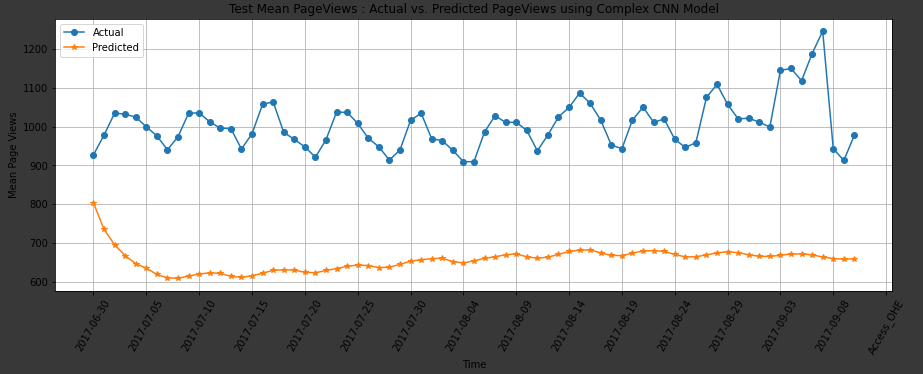

#### [4.2.5] On Test Data

In [ ]:
best_window = 90
print("LSTM Model is trained and found to have Best_Window of %d"%best_window)

past_data_cols = complete_train.columns.tolist()[-best_window-5:]
past_data_cols.insert(0, 'Page')

past_data = complete_train[past_data_cols]
#past_data.head()

#getting date columns and non_date columns
date_cols = [ x for x in past_data.columns.tolist() if '-' in x ]
non_date  = [ x for x in past_data.columns.tolist() if x not in date_cols and x != 'Page' ]

#separating the ata into series of PageViews and Site features
timeseries_X = complete_train[date_cols]

LSTM Model is trained and found to have Best_Window of 90


In [ ]:
X = np.log1p(timeseries_X.iloc[:,:-1])
#X = X_timeseries.iloc[:,-best_window-1:-1]
r, c = X.shape
X = np.array(X).reshape((r, c, 1))
Y = np.log1p(timeseries_X.iloc[:,-1])
#Y = X_timeseries.iloc[:,-1]

from tensorflow.keras.models import model_from_json
with open('complex_cnn_model.json', 'r') as f:
    model = model_from_json(f.read())
# Load weights into the new model
model.load_weights('complex_cnn_model_weights.h5')
#model.summary()
#model.fit(X, Y, batch_size=batch, epochs=epoch, verbose=1)

In [ ]:
model_test = pd.DataFrame()
model_test['Page'] = complete_train.Page.values
#print(past_data.shape)
for test_index in range(len(test_days)):
    clear_session()
    #print("Remaining are %d"%(len(test_days)-test_index+1))
    #print(history.shape)
    X = np.log1p(timeseries_X.iloc[:,-best_window:])
    r, c = X.shape
    X = np.array(X).reshape((r, c, 1))
    #X_lagged = np.hstack((X_pagename_te, X))
    predicted = np.ceil(np.expm1(model.predict(X, batch_size=batch)))
    model_test[test_days[test_index]]   = predicted
    timeseries_X[test_days[test_index]] = predicted

In [ ]:
f = open('Complex_CNN_Page_Count.csv', 'w')
f.write('Page|Visits'+'\n')
for col in model_test.iloc[:,-62:].columns.tolist():
  test_data = model_test[['Page',col]]
  test_data = test_data.replace([np.inf, -np.inf], 0)
  pageviews = [ str(int(x)) for x in test_data.iloc[:,-1] ]
  pagename  = [ x+'_'+test_data.columns.tolist()[-1] for x in test_data.iloc[:,0] ]
  page_view = list(zip(pagename,pageviews))
  #writing it into file
  for line in page_view:
    n, c = line
    f.write(n+'|'+c)
    f.write('\n')
test_data_final = pd.read_csv('./Complex_CNN_Page_Count.csv', sep='|')  

#saving the final file
page_key.merge(test_data_final, how='left', on='Page')[['Id', 'Visits']].fillna(0).to_csv('./Test_Data_Complex_CNN.csv', index=False)

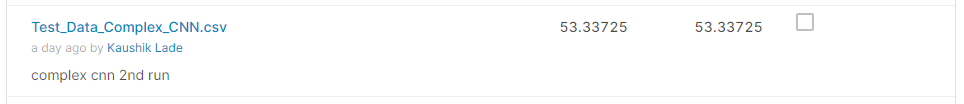

In [ ]:
models['Complex CNN'] = [best_window, cv_smape, 53.33725]

# [5] Conclusion

In [18]:
from prettytable import PrettyTable
dl_models = PrettyTable(['Model', 'Best Window', 'CV performance', 'Test Performance'])

for k, v in models.items():
    dl_models.add_row([k, v[0], round(v[1], 4)
    , v[2]])

print(dl_models)

+--------------------+-------------+----------------+------------------+
|       Model        | Best Window | CV performance | Test Performance |
+--------------------+-------------+----------------+------------------+
|     DNN Model      |      90     |    52.2255     |     79.44122     |
|     CNN Model      |      90     |    57.8225     |     46.7953      |
|     LSTM Model     |      30     |    84.4969     |     84.03305     |
| Complex LSTM Model |      7      |    91.0318     |     92.85667     |
| Complex CNN Model  |      90     |    55.5674     |     53.33725     |
+--------------------+-------------+----------------+------------------+


<p>
By building simple Deep NN models with simple sequence information of the data, we can get pretty good results of forecasting.</p> 
<p>
Modeling is done with 
<li> Deep MLP </li>
<li> Simple LSTM </li>
<li> Simple CNN </li>
<li> Combined CNN-LSTM Model </li>
<li> Complex LSTM </li>
<li> Complex CNN </li>
Out of these, we get best results with simple and 2 layered CNN models on CV data.
</p>
<p>
Comparing the model performances after increasing their complexity, i.e. by adding extra layers, we observed that the models performance slightly decreases, but the same can be maintained with the hyper-parameter tuning of each individual layers.
</p>